In [1]:
import os
import torch
import torchvision
import pickle
import copy
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from matplotlib.pyplot import imshow
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

### Load and prepare datasets

In [4]:
def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0

    for images, _ in loader:
        # Rearrange images to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total number of images
        num_pixels += images.size(0)
        # Compute mean and std here
        mean += images.mean(2).sum(0) 
        std += images.std(2).sum(0)

    mean /= num_pixels
    std /= num_pixels

    return mean, std

In [5]:
# Load the CIFAR-10 dataset
train_dataset_base = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

In [ ]:
# Compute the mean and standard deviation of the training set
trainloader0 = torch.utils.data.DataLoader(train_dataset_base, batch_size=64, shuffle=True)
mean, std = get_mean_std(trainloader0)

print(mean)
print(std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2023, 0.1994, 0.2010])


In [8]:
# Normalize the dataset
train_dataset0 = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4918, 0.4825, 0.4470), (0.2023, 0.1995, 0.2011))
                                 ])
)

In [9]:
# Split the dataset into training and validation sets
train_dataset2, val_dataset = torch.utils.data.random_split(train_dataset0, [40000, 10000])

In [ ]:
# Transform the training dataset
train_dataset_transformed = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=transforms.Compose([transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                  transforms.RandomRotation(20),     # Rotates the image to a specified angel
                                  transforms.ToTensor(), # Converts the image to tensor 
                                  transforms.Normalize((0.4918, 0.4825, 0.4470), (0.2023, 0.1995, 0.2011)) # Normalize images
                                 ])
)

print(len(train_dataset_transformed))

50000

In [11]:
# concatenate the two datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_transformed ,train_dataset2])

In [12]:
# test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.4918, 0.4825, 0.4470), (0.2023, 0.1995, 0.2011))
                                 ])
)

In [30]:
print(f"Datasets lenthgs: \n train: {len(train_dataset)} \n val: {len(val_dataset)} \n test: {len(test_dataset)}")

Datasets lenthgs: 
 train: 90000 
 val: 10000 
 test: 10000


In [14]:
print(test_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Dataloaders

In [15]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) # po augmentacji

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False) # testowy

validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False) # walidacyjny

In [41]:
print(len(trainloader))
print(len(testloader))
print(len(validation_loader))

2813
313
313


### Pictures before transformations

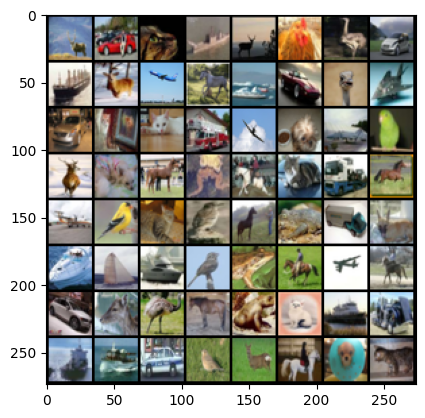

In [42]:
# Image Visualization

images, labels = next(iter(trainloader0))


def image_viz(img):
    image = img.numpy()
    image = np.transpose(image, (1, 2, 0))
    imshow(image)
fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

### Pictures after transformations (train dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


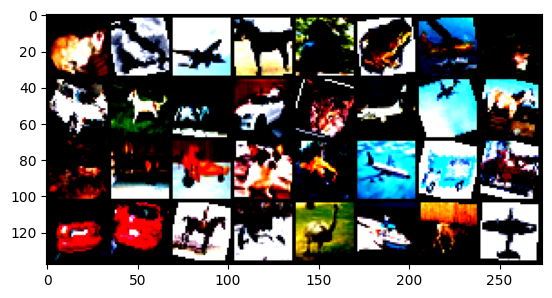

In [17]:
images, labels = next(iter(trainloader))
fullgrid = torchvision.utils.make_grid(images)
image_viz(fullgrid)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Get the current device index
print(torch.cuda.get_device_name(0))  # Print the name of the GPU

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


### Convolutional neural net

In [33]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()                       
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.15),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
            

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

### Training loop

In [22]:
def train(model, train_dataloader, validation_dataloader, loss_fn, optimizer, num_epoch, device):
    
    train_loss_list = []  # training loss 
    train_acc_list = []  # training accuracy
    val_loss_list = [] # validation loss
    val_acc_list = [] # validation accuracy
    
    # variables for early stopping
    best_loss = float('inf')
    patience = 10
    best_model_weights = None
    
    for epoch in range(num_epoch):
        running_loss = 0
        corrects = 0
        val_running_loss = 0
        val_corrects = 0
        n=0
        val_n=0
        
        model.train()
        for batch in train_dataloader:
            images, labels = batch
            
            #Puta data on target device
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculating accuracy
            _, preds = torch.max(outputs, 1)
            corrects += (preds == labels).sum().item()
            n += labels.size(0)

        train_loss_list.append(running_loss / len(train_dataloader)) # loss per epoch
        train_acc_list.append(100* corrects / n) #acc per epoch

        
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in validation_dataloader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_labels)
                val_running_loss += val_loss.item()

                _, val_preds = torch.max(val_outputs, 1)
                val_corrects += (val_preds == val_labels).sum().item()
                val_n += val_labels.size(0)



        val_loss_list.append(val_running_loss / len(validation_dataloader))
        val_acc_list.append(100 * val_corrects / val_n)

        if epoch % 10 == 0 or epoch-1 == num_epoch:
            print(f'Epoch [{epoch+1}/{num_epoch}]')
            print(f'\t validation loss: {val_loss_list[epoch]}, validation accuracy: {val_acc_list[epoch]}')
            print(f'\t training loss: {train_loss_list[epoch]}, training accuracy: {train_acc_list[epoch]}')

        
        # Early stopping
        if val_loss_list[epoch] < best_loss:
            best_loss = val_loss_list[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())   
            patience = 10  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print(f"early stopping at epoch {epoch+1}")
                break
    
    
    model.load_state_dict(best_model_weights)
    return {"val_loss": val_loss_list, "val_acc": val_acc_list, "train_loss": train_loss_list, "train_acc": train_acc_list}
        

### Model eval function

In [23]:

def evaluation(dataloader, model, loss_fn):
    model.eval()
    classes = test_dataset.classes
    total, correct = 0, 0
    class_correct = [0 for i in range(10)]
    class_total = [0 for i in range(10)]
    running_loss = 0
    n=0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            pred = model.forward(images)
            _, predicted = torch.max(pred.data, 1)

            #Calculating loss
            loss = loss_fn(pred, labels)
            running_loss += loss.item()

            #Calculating accuracy
            n += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            #Calculating accuracy per batch
            for i in range(labels.size(0)):  
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    class_correct[label] += 1
                class_total[label] += 1
                
        acc = 100.0 * correct / n
        print(f'Accuracy of the network: {acc} %')
        print(f"Loss: {running_loss / n} \n")
        
        print("Accuracy per class: ")
        for i in range(10):
            acc = 100.0 * class_correct[i] / class_total[i]
            print(f'Accuracy of {classes[i]}: {acc} %')



### Model structure

In [34]:
mod2 = Net2().to(device)

summary(mod2, [1,3,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─ReLU: 2-10                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          147,584

### Training

In [35]:
loss_fn1 = torch.nn.CrossEntropyLoss()

optimizer2 = torch.optim.Adam(mod2.parameters(), lr=0.001)

train_mod2 = train(model=mod2,
                  train_dataloader=trainloader,
                  loss_fn=loss_fn1,
                  num_epoch=100,
                  optimizer=optimizer2,
                  validation_dataloader=validation_loader,
                  device=device)

Epoch [1/100]
	 validation loss: 0.9361408792745572, validation accuracy: 66.57
	 training loss: 1.333654931801051, training accuracy: 51.29222222222222
Epoch [11/100]
	 validation loss: 0.2707835889091126, validation accuracy: 90.95
	 training loss: 0.36503949497190397, training accuracy: 87.61555555555556
Epoch [21/100]
	 validation loss: 0.1634811993045643, validation accuracy: 94.52
	 training loss: 0.2471808658084586, training accuracy: 91.76555555555555
Epoch [31/100]
	 validation loss: 0.13194561952921435, validation accuracy: 95.44
	 training loss: 0.19894795421904254, training accuracy: 93.40222222222222
Epoch [41/100]
	 validation loss: 0.09946003927887914, validation accuracy: 96.79
	 training loss: 0.173844382000413, training accuracy: 94.27444444444444
Epoch [51/100]
	 validation loss: 0.07694202387138618, validation accuracy: 97.46
	 training loss: 0.15249244310814322, training accuracy: 94.95111111111112
Epoch [61/100]
	 validation loss: 0.06083901185942546, validation a

### Saving model

In [36]:
with open("train_mod2", "wb") as fp: #Pickling
    pickle.dump(train_mod2, fp)


torch.save(mod2, "model2.pth")

In [35]:
#with open("train_mod2", "rb") as fp:   # Unpickling
#    train_mod2 = pickle.load(fp)

In [34]:
#mod2 = torch.load("model2.pth", weights_only=False, map_location=torch.device(device))
#mod2.eval()

### Vizualizations

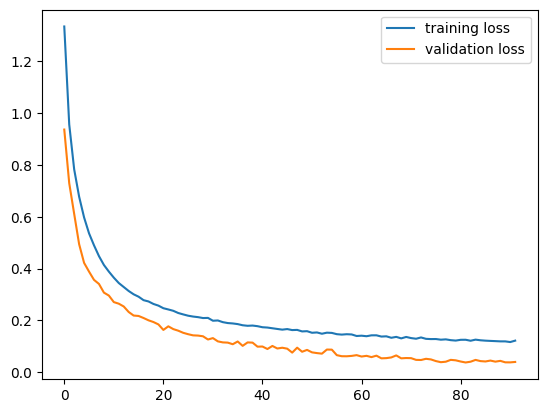

In [43]:
plt.plot(train_mod2["train_loss"], label = "training loss")
plt.plot(train_mod2["val_loss"], label = "validation loss")
plt.legend()
plt.show()

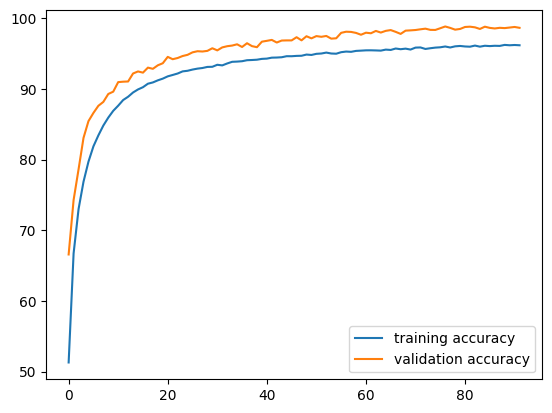

In [44]:
plt.plot(train_mod2["train_acc"], label = "training accuracy")
plt.plot(train_mod2["val_acc"], label = "validation accuracy")
plt.legend()
plt.show()

### Accuracy on test data

In [39]:
evaluation(testloader, mod2, loss_fn1)

Accuracy of the network: 90.72 %
Loss: 0.012150155793817247 

Accuracy per class: 
Accuracy of airplane: 91.7 %
Accuracy of automobile: 95.2 %
Accuracy of bird: 86.2 %
Accuracy of cat: 80.7 %
Accuracy of deer: 90.7 %
Accuracy of dog: 87.4 %
Accuracy of frog: 93.7 %
Accuracy of horse: 92.5 %
Accuracy of ship: 95.3 %
Accuracy of truck: 93.8 %


In [28]:
def plot_conf_mat(model):
    preds_list = []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
    
            # Forward pass
            pred = model.forward(images)
            _, predicted = torch.max(pred.data, 1)
            preds_list.extend(predicted.cpu())
    
    
    c_f = confusion_matrix(preds_list, test_dataset.targets)
    
    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat= c_f, 
        class_names=test_dataset.classes,
        figsize=(10, 7))

### Confusion matrix

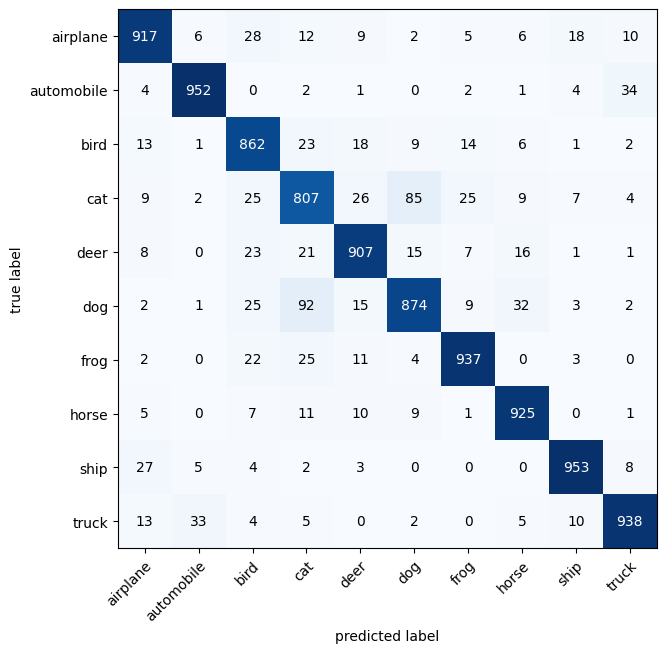

In [40]:
plot_conf_mat(mod2)

### ------------------------------------------------------------------------